## Analyzing Company Revenue Data for Marketing

This report is a deep dive into the revenue data generated by a mobile communications company, Megaline [practice dataset]. Our client Megaline offered two different phone plans in 2018, Ultimate and Surf. They have collected information on user behavior such as who the clients are, where they're from, which plan they are on, the number of calls they made, how much data they used and text messages they sent in 2018.

This report analyzes user behavior and identifies which plan produced the most revenue for Megaline in 2018. This report finds that the Surf plan generated more revenue for Megaline overall. Our findings were supported statistically: We conducted a one-tailed t-test that showed there was a statistically significant difference between the monthly revenue brought in by Surf users and the monthly revenue brought in by Ultimate users. 

Our data visualizations, however showed the more interesting details and connections between users and revenue generated under each plan. We can see that Surf is a cheaper plan however its users had a tendency to go over their plan limits for minutes, text messages and data quite often. On the other hand, Ultimate users were conservative with their allowances and rarely accrued fees for exceeding minutes, texts or calls on their plan. 

This report finds that the current marketing strategy has been successful and driven by user's beliefs on which plan is a better "deal" for them. It is advisable to keep both plans, as users who are presented with two different price points and package deals will sometimes push them to select the Ultimate plan. Although the Ultimate plan is available at a higher price point, users may believe this package deal is their best option since it will definitely cover their usage needs. 

## Importing Data and Libraries

Our client has offered to us 5 different data tables on user behavior. To begin this analysis, we will open up each of the data sources and inspect them below. 

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# Importing data sources
user_data = pd.read_csv('/Users/mitzibandera/Data Files/Phone Plan/megaline_users1.csv')
calls_data = pd.read_csv('/Users/mitzibandera/Data Files/Phone Plan/megaline_calls.csv')
internet_data = pd.read_csv('/Users/mitzibandera/Data Files/Phone Plan/megaline_internet.csv')
messages_data = pd.read_csv('/Users/mitzibandera/Data Files/Phone Plan/megaline_messages.csv')
plans_data = pd.read_csv('/Users/mitzibandera/Data Files/Phone Plan/megaline_plans.csv')

## Data Pre-Processing

#### Data on users

In [3]:
# Inspecting data 
user_data.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [4]:
# Inspecting data 
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
# Checking for duplicates 
duplicate_data = user_data.duplicated(subset = ['user_id'], keep = 'first') 
print(duplicate_data.value_counts())

False    500
dtype: int64


In [6]:
# Changing reg_date to date and time data type
user_data['reg_date'] = pd.to_datetime(user_data['reg_date'], format = '%Y-%m-%d')
# Changing churn_date to date and time data type
user_data['churn_date'] = pd.to_datetime(user_data['churn_date'], format = '%Y-%m-%d')

In [7]:
# Looking for missing values using isnull()
print(user_data.columns[user_data.isnull().any()])

Index(['churn_date'], dtype='object')


In [8]:
# Filling in missing values in churn_date with the last day of the year 2018 since customers were still active
user_data['churn_date'] = user_data['churn_date'].fillna(value = '2018-12-31')
# Again changing churn_date to date and time data type because it had changed back to object data type 
user_data['churn_date'] = pd.to_datetime(user_data['churn_date'], format = '%Y-%m-%d')

In [9]:
# Creating a column showing how many months the user was active with Megaline in 2018 
import numpy as np 
user_data['total_months_active'] = round(((user_data.churn_date - user_data.reg_date)/np.timedelta64(1, 'M')))
user_data['total_months_active'].value_counts()

10.0    50
7.0     50
6.0     48
11.0    48
5.0     48
4.0     40
1.0     39
2.0     39
3.0     35
8.0     34
9.0     33
0.0     19
12.0    17
Name: total_months_active, dtype: int64

We'll understand 0 months to signify users who weren't active with Megaline for a whole month. In this case, we will round up to 1 month.

In [10]:
# Replacing '0.0' months with '1.0'
user_data['total_months_active'] = user_data['total_months_active'].replace({0:1})

#### Data on calls and minutes used

In [11]:
# Inspecting data 
calls_data.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [12]:
# Inspecting data 
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Checking for duplicates 
duplicate_data = calls_data.duplicated(subset = ['id','call_date', 'user_id'], keep = 'first') 
print(duplicate_data.value_counts())

False    137735
dtype: int64


In [14]:
# Changing call_date to date and time data type
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format = '%Y-%m-%d')

In [15]:
# For calls, each individual call is rounded up: even if the call lasted just one second
    # it will be counted as one minute
calls_data['duration'] = np.ceil(calls_data['duration'])

In [16]:
# Looking for missing values using isnull()
print(calls_data.columns[calls_data.isnull().any()])

Index([], dtype='object')


In [17]:
# Aggregating minutes used per month

# Keeping just the month the call was made in
calls_data['month'] = pd.DatetimeIndex(calls_data['call_date']).month
# Creating a pivot table to aggregate the minutes used per month per client 
calls_data_table = pd.pivot_table(calls_data, index = ['user_id', 'month'],
                                values = ['duration'], aggfunc = [np.sum])
# Display table
calls_data_table

sum
              duration
user_id month         
1000    12       124.0
1001    8        182.0
        9        315.0
        10       393.0
        11       426.0
...                ...
1498    12       339.0
1499    9        346.0
        10       385.0
        11       308.0
        12       496.0

[2258 rows x 1 columns]

#### Data on internet usage

In [18]:
# Inspecting data 
internet_data.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [19]:
# Inspecting data 
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [20]:
# Checking for duplicates 
duplicate_data = internet_data.duplicated(subset = ['id','session_date', 'user_id'], keep = 'first') 
print(duplicate_data.value_counts())

False    104825
dtype: int64


In [21]:
# Changing session_date to date and time data type
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format = '%Y-%m-%d')

In [22]:
# Looking for missing values using isnull()
print(internet_data.columns[internet_data.isnull().any()])

Index([], dtype='object')


In [23]:
# Aggregating megabytes used per month

# Keeping just the month the data was used in
internet_data['month'] = pd.DatetimeIndex(internet_data['session_date']).month
# Creating a pivot table to aggregate the data used per month per client 
internet_data_table = pd.pivot_table(internet_data, index = ['user_id', 'month'],
                                values = ['mb_used'], aggfunc = [np.sum])
# Display table
internet_data_table

sum
                mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
...                 ...
1498    12     23137.69
1499    9      12984.76
        10     19492.43
        11     16813.83
        12     22059.21

[2277 rows x 1 columns]

In [24]:
# Adding a new column to show gb_used instead of mb_used
internet_data_table['gb_used'] = internet_data_table[('sum', 'mb_used')]/1000
# Rounding up: For web traffic, the total for the month is rounded up. 
    # If someone uses 1025 megabytes this month, they will be charged for 2 gigabytes.
internet_data_table['gb_used'] = np.ceil(internet_data_table['gb_used'])
internet_data_table

sum gb_used
                mb_used        
user_id month                  
1000    12      1901.47     2.0
1001    8       6919.15     7.0
        9      13314.82    14.0
        10     22330.49    23.0
        11     18504.30    19.0
...                 ...     ...
1498    12     23137.69    24.0
1499    9      12984.76    13.0
        10     19492.43    20.0
        11     16813.83    17.0
        12     22059.21    23.0

[2277 rows x 2 columns]

#### Data on messages sent

In [25]:
# Inspecting data 
messages_data.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [26]:
# Inspecting data 
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [27]:
# Changing user_id data type to string
# messages_data['user_id'] = str(messages_data['user_id'])
# Changing message_date to date and time data type
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format = '%Y-%m-%d')

In [28]:
# Looking for missing values using isnull()
print(messages_data.columns[messages_data.isnull().any()])

Index([], dtype='object')


In [29]:
# Checking for duplicates 
duplicate_data = messages_data.duplicated(subset = ['id','message_date', 'user_id'], keep = 'first') 
print(duplicate_data.value_counts())

False    76051
dtype: int64


In [30]:
# Aggregating messages sent per month

# Keeping just the month the message was sent in
messages_data['month'] = pd.DatetimeIndex(messages_data['message_date']).month
# Creating a pivot table to aggregate the messages sent per month per client 
messages_data_table = pd.pivot_table(messages_data, index = ['user_id', 'month'],
                                values = ['message_date'], aggfunc = [len])
# Display table
messages_data_table

len
              message_date
user_id month             
1000    12              11
1001    8               30
        9               44
        10              53
        11              36
...                    ...
1496    9               21
        10              18
        11              13
        12              11
1497    12              50

[1806 rows x 1 columns]

In [31]:
# Converting from integer to float 
# messages_data_table[('len','message_date')] = float(messages_data_table[('len','message_date')])

#### Data on Megaline plans

In [32]:
# Inspecting data 
plans_data.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [33]:
# Inspecting data 
plans_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [34]:
# Naming a column 'plan' so I can merge tables later on
plans_data = plans_data.rename(columns={"plan_name": 'plan'})
# Creating a new column to show gb data used (not just mb)
plans_data['gb_per_month_included'] = plans_data['mb_per_month_included']/1000
plans_data.head(3)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.36
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.72


## Merging data tables

The user data table that we first imported had good and detailed information that we'll want to merge it with the rest of our tables below. Especially because having all of the information together for each client will help us to draw conclusions about monthly dues. 

In [35]:
# Merging our pivot tables: calls_data_table, internet_data_table, messages_data_table
phone_data = messages_data_table.merge(calls_data_table, how='left', on=['user_id', 'month'])
phone_data = phone_data.merge(internet_data_table, how = 'left', on = ['user_id', 'month'])
phone_data.head(3)

len      sum           gb_used
              message_date duration   mb_used        
user_id month                                        
1000    12              11    124.0   1901.47     2.0
1001    8               30    182.0   6919.15     7.0
        9               44    315.0  13314.82    14.0

In [36]:
# Merging with user and phone data
phone_data = phone_data.merge(user_data, how = 'left', on = ['user_id'])

/Users/mitzibandera/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [37]:
# Renaming columns for accuracy 
phone_data = phone_data.rename(columns={('len', 'message_date'): 'messages_used_month'})
phone_data = phone_data.rename(columns={('sum', 'duration'): 'minutes_used_month'})
phone_data = phone_data.rename(columns={('sum', 'mb_used'): 'mb_used_month'})
phone_data = phone_data.rename(columns={('gb_used', ''): 'gb_used_month'})

In [38]:
# Merging with user and phone data
phone_data = phone_data.merge(plans_data, how = 'left', on = ['plan'])

In [39]:
# Inspecting merged table
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1806 entries, 0 to 1805
Data columns (total 21 columns):
user_id                  1806 non-null int64
messages_used_month      1806 non-null int64
minutes_used_month       1773 non-null float64
mb_used_month            1791 non-null float64
gb_used_month            1791 non-null float64
first_name               1806 non-null object
last_name                1806 non-null object
age                      1806 non-null int64
city                     1806 non-null object
reg_date                 1806 non-null datetime64[ns]
plan                     1806 non-null object
churn_date               1806 non-null datetime64[ns]
total_months_active      1806 non-null float64
messages_included        1806 non-null int64
mb_per_month_included    1806 non-null int64
minutes_included         1806 non-null int64
usd_monthly_pay          1806 non-null int64
usd_per_gb               1806 non-null int64
usd_per_message          1806 non-null float64
usd_pe

In [40]:
# Inspecting merged table
phone_data.head()

,user_id,messages_used_month,minutes_used_month,mb_used_month,gb_used_month,first_name,last_name,age,city,reg_date,...,churn_date,total_months_active,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included
0,1000,11,124.0,1901.47,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,...,2018-12-31,1.0,1000,30720,3000,70,7,0.01,0.01,30.72
1,1001,30,182.0,6919.15,7.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,2018-12-31,5.0,50,15360,500,20,10,0.03,0.03,15.36
2,1001,44,315.0,13314.82,14.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,2018-12-31,5.0,50,15360,500,20,10,0.03,0.03,15.36
3,1001,53,393.0,22330.49,23.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,2018-12-31,5.0,50,15360,500,20,10,0.03,0.03,15.36
4,1001,36,426.0,18504.30,19.0,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,...,2018-12-31,5.0,50,15360,500,20,10,0.03,0.03,15.36


## Step 4: Eliminating Outliers

Before we can really draw conclusions about customer behavior, we'll have to eliminate outliers. 

In [41]:
# Inspecting data length before deleting outliers 
len(phone_data)

1806

In [42]:
# Removing outliers from messages_used_month
z_scores = st.zscore(phone_data['messages_used_month'])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3) 
phone_data = phone_data[filtered_entries]

In [43]:
# # Removing outliers from minutes_used_month
# z_scores = st.zscore(phone_data['minutes_used_month'])
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3) 
# phone_data = phone_data[filtered_entries]

In [44]:
# # Removing outliers from gb_used_month
# z_scores = st.zscore(phone_data['gb_used_month'])
# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3) 
# phone_data = phone_data[filtered_entries]

In [45]:
# Inspecting new data length without outliers 
len(phone_data)

1775

## Step 5: New Calculations

We've already done some data preprocessing in the previous steps, and now we'll take it one step further. In the section below, we'll be working with each individual plan to find out how many minutes, messages and data each client had access to during their time with Megaline. We'll also be finding out how many fees they accrued if they went over their plan allowances and lastly, how much revenue each client brought in to Megaline. 

In order to get a bigger picture of how much revenue each plan brings in, we'll need to add a column to our table showing the accrued fees per client per service. For example, we'll want to know if a client exceeded their monthly minutes allowance; if a client exceeded their allowance, we'll want to know how much this cost them given their phone plan. 

By creating this column, we can also easily build on it to find out how much revenue each client brought in when we consider the plan charge and added fees.

#### Calculating Minutes, Texts, Data Exceeded

In [46]:
# Creating a function to show how many minutes a client exceeded 
def minutes_exceeded(row):
    if row['minutes_used_month'] > row['minutes_included']:
        return (row['minutes_used_month'] - row['minutes_included'])
    else:
        return 0
# Applying function to data and adding results as a new column
phone_data['minutes_exceeded'] = phone_data.apply(minutes_exceeded, axis=1)

In [47]:
# Creating a function to show how many messages a client exceeded 
def messages_exceeded(row):
    if row['messages_used_month'] > row['messages_included']:
        return (row['messages_used_month'] - row['messages_included'])
    else:
        return 0
# Applying function to data and adding results as a new column
phone_data['messages_exceeded'] = phone_data.apply(messages_exceeded, axis=1)

In [48]:
# Creating a function to show how much data a client exceeded 
def data_exceeded(row):
    if row['gb_used_month'] > row['gb_per_month_included']:
        return (row['gb_used_month'] - row['gb_per_month_included'])
    else:
        return 0
# Applying function to data and adding results as a new column
phone_data['data_exceeded'] = phone_data.apply(data_exceeded, axis=1)

#### Calculating Accrued Fees

In [49]:
# Adding a column to show accrued fees for minutes exceeded
phone_data['minutes_exceeded_fees'] = phone_data['minutes_exceeded'] * phone_data['usd_per_minute']
# Adding a column to show accrued fees for messages exceeded
phone_data['messages_exceeded_fees'] = phone_data['messages_exceeded'] * phone_data['usd_per_message']
# Adding a column to show accrued fees for data exceeded
phone_data['data_exceeded_fees'] = phone_data['data_exceeded'] * phone_data['usd_per_gb']

#### Calculating Revenue Per Client Per Month

In [50]:
# Adding a column to show total revenue per client per month
phone_data['monthly_revenue'] = phone_data['data_exceeded_fees'] + phone_data['messages_exceeded_fees'] + phone_data['minutes_exceeded_fees'] + phone_data['usd_monthly_pay']


## Step 6: Analyzing Customer Behavior

We'll also take this opportunity to look at the distribution of customer behavior. Specifically, we'll want to take a look at the mean, dispersion, and standard deviation in the describe() table. 

#### Querying for Surf vs. Ultimate customers 

In [51]:
# Creating two subsets of data, one for Surf and the other for Ultimate
surf_data = phone_data.query("plan in 'surf'")
ultimate_data = phone_data.query("plan in 'ultimate'")

## How often do Surf and Ultimate customers text, call or message?

#### Surf Customers

In [52]:
surf_data.describe()

,user_id,messages_used_month,minutes_used_month,mb_used_month,gb_used_month,age,total_months_active,messages_included,mb_per_month_included,minutes_included,...,usd_per_message,usd_per_minute,gb_per_month_included,minutes_exceeded,messages_exceeded,data_exceeded,minutes_exceeded_fees,messages_exceeded_fees,data_exceeded_fees,monthly_revenue
count,1201.000000,1201.000000,1173.000000,1191.000000,1191.000000,1201.000000,1201.000000,1201.0,1201.0,1201.0,...,1.201000e+03,1.201000e+03,1.201000e+03,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000,1201.000000
mean,1242.766861,37.968360,439.886616,16591.837767,17.077246,44.820983,7.435470,50.0,15360.0,500.0,...,3.000000e-02,3.000000e-02,1.536000e+01,62.910075,7.216486,3.856420,1.887302,0.216495,38.564197,60.667993
std,134.206969,28.789593,232.729636,7920.206790,7.909195,16.702208,3.051127,0.0,0.0,0.0,...,5.067503e-16,5.067503e-16,2.594561e-13,128.898145,16.512160,5.540575,3.866944,0.495365,55.405745,56.370188
min,1001.000000,1.000000,2.000000,92.310000,1.000000,18.000000,1.000000,50.0,15360.0,500.0,...,3.000000e-02,3.000000e-02,1.536000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
25%,1127.000000,16.000000,282.000000,12277.635000,13.000000,29.000000,5.000000,50.0,15360.0,500.0,...,3.000000e-02,3.000000e-02,1.536000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.060000
50%,1245.000000,32.000000,437.000000,16751.520000,17.000000,45.000000,8.000000,50.0,15360.0,500.0,...,3.000000e-02,3.000000e-02,1.536000e+01,0.000000,0.000000,1.640000,0.000000,0.000000,16.400000,39.100000
75%,1349.000000,52.000000,582.000000,20835.905000,21.000000,61.000000,10.000000,50.0,15360.0,500.0,...,3.000000e-02,3.000000e-02,1.536000e+01,79.000000,2.000000,5.640000,2.370000,0.060000,56.400000,80.800000
max,1496.000000,141.000000,1510.000000,70931.590000,71.000000,75.000000,12.000000,50.0,15360.0,500.0,...,3.000000e-02,3.000000e-02,1.536000e+01,1010.000000,91.000000,55.640000,30.300000,2.730000,556.400000,596.770000


#### Ultimate Customers

In [53]:
ultimate_data.describe()

,user_id,messages_used_month,minutes_used_month,mb_used_month,gb_used_month,age,total_months_active,messages_included,mb_per_month_included,minutes_included,...,usd_per_message,usd_per_minute,gb_per_month_included,minutes_exceeded,messages_exceeded,data_exceeded,minutes_exceeded_fees,messages_exceeded_fees,data_exceeded_fees,monthly_revenue
count,574.000000,574.000000,569.000000,573.000000,573.000000,574.000000,574.000000,574.0,574.0,574.0,...,5.740000e+02,5.740000e+02,5.740000e+02,574.0,574.0,574.000000,574.0,574.0,574.000000,574.000000
mean,1248.461672,44.465157,439.815466,17124.935934,17.628272,47.923345,7.313589,1000.0,30720.0,3000.0,...,1.000000e-02,1.000000e-02,3.072000e+01,0.0,0.0,0.344321,0.0,0.0,2.410244,72.410244
std,150.207458,30.123156,249.475568,7715.727073,7.721306,16.805147,2.881473,0.0,0.0,0.0,...,1.354264e-16,1.354264e-16,1.849022e-13,0.0,0.0,1.647171,0.0,0.0,11.530197,11.530197
min,1000.000000,1.000000,0.000000,290.060000,1.000000,18.000000,1.000000,1000.0,30720.0,3000.0,...,1.000000e-02,1.000000e-02,3.072000e+01,0.0,0.0,0.000000,0.0,0.0,0.000000,70.000000
25%,1124.500000,20.000000,262.000000,12670.490000,13.000000,34.000000,5.000000,1000.0,30720.0,3000.0,...,1.000000e-02,1.000000e-02,3.072000e+01,0.0,0.0,0.000000,0.0,0.0,0.000000,70.000000
50%,1236.000000,40.000000,421.000000,16708.540000,17.000000,49.000000,7.000000,1000.0,30720.0,3000.0,...,1.000000e-02,1.000000e-02,3.072000e+01,0.0,0.0,0.000000,0.0,0.0,0.000000,70.000000
75%,1391.000000,65.000000,573.000000,20689.950000,21.000000,64.000000,10.000000,1000.0,30720.0,3000.0,...,1.000000e-02,1.000000e-02,3.072000e+01,0.0,0.0,0.000000,0.0,0.0,0.000000,70.000000
max,1497.000000,139.000000,1369.000000,46595.330000,47.000000,75.000000,12.000000,1000.0,30720.0,3000.0,...,1.000000e-02,1.000000e-02,3.072000e+01,0.0,0.0,16.280000,0.0,0.0,113.960000,183.960000


#### Mean or Median? 

Whenever a graph falls on a normal distribution, using the mean is a good choice. But if our data has extreme scores (such as the difference between a millionaire and someone making 30,000 a year), we will need to look at the median, because we'll find a much more representative number for our sample.

### Histograms

Given the mean and median showed above are considerably different, this indicates that the data is skewed (i.e. they are far from being normally distributed) and the median generally gives a more appropriate idea of the data distribution. Histograms can give us better idea about the skew in the data.

##### Messages Sent

Text(0, 0.5, 'Count')

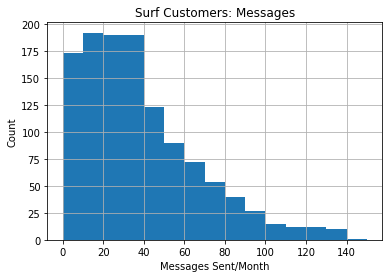

In [54]:
# Plotting a histogram for the messages sent by Surf customers
surf_data['messages_used_month'].hist(bins = 15, range = (0,150))
plt.title('Surf Customers: Messages')
plt.xlabel('Messages Sent/Month')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

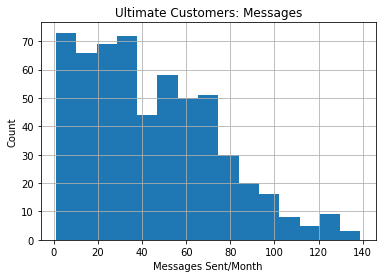

In [55]:
# Plotting a histogram for the messages sent by Ultimate customers
ultimate_data['messages_used_month'].hist(bins = 15)
plt.title('Ultimate Customers: Messages')
plt.xlabel('Messages Sent/Month')
plt.ylabel('Count')

The very first thing we see is that our histograms tend to skew towards the right. Here it's important to remember that Surf customers should only be sending a maximum of 50 messages a month, while Ultimate customers have more flexiblity. They are permitted to send up to 1000 messages. The histograms clearly show that Surf users go over their permitted limit time and time again. While Ultimate customers did not exceed their alloance, not even once. 

##### Minutes Used 

Text(0, 0.5, 'Count')

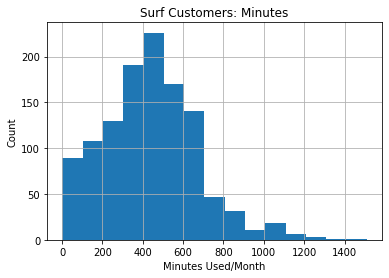

In [56]:
# Plotting a histogram for the minutes used by Surf customers
surf_data['minutes_used_month'].hist(bins = 15)
plt.title('Surf Customers: Minutes')
plt.xlabel('Minutes Used/Month')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

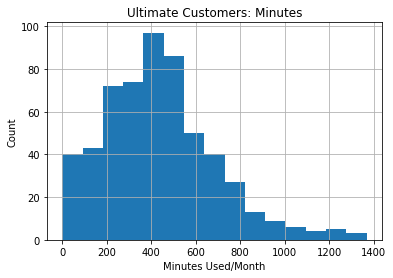

In [57]:
# Plotting a histogram for the minutes used by Ultimate customers
ultimate_data['minutes_used_month'].hist(bins = 15)
plt.title('Ultimate Customers: Minutes')
plt.xlabel('Minutes Used/Month')
plt.ylabel('Count')

Here we begin to see semblances of a bell curve. We see that while some customers use a lot of minutes, others do not, and somewhere in the middle of the two extremems lies the mean. For Ultimate and Surf customers, this number is around 400. This leaves a lot of room for Ultimate customers to not worry about exceeding their 3000 minute limit. However, Surf customers only have 500 allotted minutes, and they will likely be under more stress to not reach their limit and have to pay fees. 

##### Data Used 

Text(0, 0.5, 'Count')

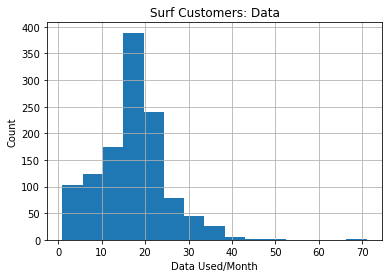

In [58]:
# Plotting a histogram for the data used by Surf customers
surf_data['gb_used_month'].hist(bins = 15)
plt.title('Surf Customers: Data')
plt.xlabel('Data Used/Month')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

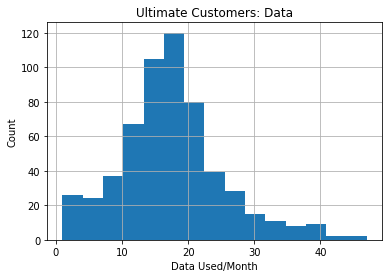

In [59]:
# Plotting a histogram for the data used by Ultimate customers
ultimate_data['gb_used_month'].hist(bins = 15)
plt.title('Ultimate Customers: Data')
plt.xlabel('Data Used/Month')
plt.ylabel('Count')

Here we also see a curve that is somewhere between bell shaped, but with a distinctive right skew. Here we see that both Ultimate and Surf customers are exceeding their monthly limits of 15gb and 30gb, respectively. We see the strongest departure from the allotted data with Surf customers, with many customers using more than the alloted 15gb of data. 

### Conclusion

Using mean values from the describe() tables and our histograms, our data shows that in 2018: 
- Surf customers sent 32 messages per month, and Ultimate customers sent 41 messages. 
- Surf and Ultimate customers used 17 gb data per month.
- Surf customers used 439 minutes per month, and Ultimate customers used 424 minutes.

## Which plan brought in the highest revenue? Surf or Ultimate? 

Text(0, 0.5, 'Count')

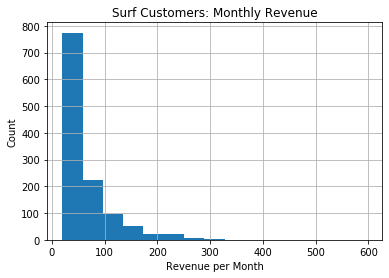

In [60]:
# Plotting a histogram for the total revenue brought in by Ultimate customers
surf_data['monthly_revenue'].hist(bins = 15)
plt.title('Surf Customers: Monthly Revenue')
plt.xlabel('Revenue per Month')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

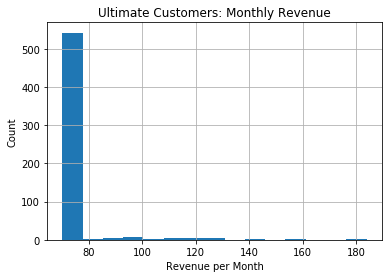

In [61]:
# Plotting a histogram for the total revenue brought in by Surf customers
ultimate_data['monthly_revenue'].hist(bins = 15)
plt.title('Ultimate Customers: Monthly Revenue')
plt.xlabel('Revenue per Month')
plt.ylabel('Count')

##### Revenue Added Up for the Year

In [62]:
#Calculating revenue from Surf users
surf_money = round(sum(surf_data['monthly_revenue']))
#Calculating revenue from Surf users
ultimate_money = round(sum(ultimate_data['monthly_revenue']))
print('Megaline gained a total of', surf_money, 'USD from Surf users in 2018.')
print('Megaline gained a total of', ultimate_money, 'USD from Ultimate users in 2018.')

Megaline gained a total of 72862 USD from Surf users in 2018.
Megaline gained a total of 41563 USD from Ultimate users in 2018.


How many customers are representing each phone plan in the rest of today's analysis? 

In [63]:
# Grouping surf_data by user 
surf_pivot = pd.pivot_table(surf_data, index = ['user_id'],
                                values = ['monthly_revenue'], aggfunc = [len])
# Calculating number of Surf customers in dataset 
surf_num = len(surf_pivot)
# Grouping ultimate_data by user 
ultimate_pivot = pd.pivot_table(ultimate_data, index = ['user_id'],
                                values = ['monthly_revenue'], aggfunc = [len])
# Calculating number of Surf customers in dataset 
ultimate_num = len(ultimate_pivot)

In [64]:
print('There are', surf_num, 'Surf customers in this data')
print('There are', ultimate_num, 'Ultimate customers in this data')

There are 270 Surf customers in this data
There are 131 Ultimate customers in this data


In [65]:
print('Surf users account for', round((surf_num/(surf_num+ultimate_num)) * 100),'% of all the Megaline client base. And they account for', round((surf_money/(surf_money+ultimate_money)) * 100),"% of the company's overall revenue.")
     

Surf users account for 67 % of all the Megaline client base. And they account for 64 % of the company's overall revenue.


### Conclusion 

- On a monthly basis, Megaline gained a median of 40.86 USD per Surf customer every month. This is a departure from the Surf phone plan base price of 20 USD. Megaline gained a median of 70 USD per Ultimate customer every month. 70 USD is the equivalent of the Ultimate phone plan base price. 
- In 2018, the majority of Megaline's revenue came from their Surf users. 

##  Step 7: Comparing phone plans (Testing between groups)

In our last step of the data analysis, we'll want to confirm the differences we've observed in revenue generated by each plan that we found through our visualizations above. We call this testing between groups, and will be testing a hypothesis on the equality of two group means. The first group being users with Surf and the second group being users with Ultimate. 

We start with the null hypothesis H₀ (from Ancient Greek ὑπόθεσις, meaning “proposal”). Our null hypothesis here is that the difference in the mean revenue for the Surf cohort versus the Ultimate cohort does not represent a statistically significant difference.

The alternative hypothesis, H₁, is based on H₀. For this H₀, H₁ is that the difference in the mean revenue for the Surf cohort versus the Ultimate cohort does represent a statistically significant difference.

To test the hypothesis, well be using the SciPy library and the st.ttest_ind() code below. 

In [66]:
surf_revenue_mean = surf_data['monthly_revenue']
ultimate_revenue_mean = ultimate_data['monthly_revenue']

# Setting a critical statistical significance level
alpha = .05 

# Testing the hypothesis that the means of the two independent populations are equal
results = st.ttest_ind(
        surf_revenue_mean, 
        ultimate_revenue_mean)

print('p-value:', results.pvalue)

# Comparing the p-value with the statistical significance level
if (results.pvalue < alpha): 
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 8.512322845358103e-07
We reject the null hypothesis


We also want to know if the average revenue from users in NY-NJ area is different from that of the users from other regions.

In [67]:
# Merging surf data and ultimate data tables 
vertical_stack = pd.concat([surf_data,ultimate_data], axis=0)

# Creating a subset of surf_data and ultimate_data to only include users in NY-NJ area
ny_nj_revenue = vertical_stack.query("city in 'New York-Newark-Jersey City, NY-NJ-PA MSA'")
other_regions = vertical_stack.query("city not in 'New York-Newark-Jersey City, NY-NJ-PA MSA'")

ny_nj_revenue_mean = ny_nj_revenue['monthly_revenue']
other_regions_revenue_mean = other_regions['monthly_revenue']

# Setting a critical statistical significance level
alpha = .05 

# Testing the hypothesis that the means of the two independent populations are equal
results = st.ttest_ind(
        ny_nj_revenue_mean, 
        other_regions_revenue_mean)

print('p-value:', results.pvalue)

# Comparing the p-value with the statistical significance level
if (results.pvalue < alpha): 
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.09498190456575879
We can't reject the null hypothesis


Our statistical tests show that there is not a significant difference in the monthly revenue generated by users in the NY-NJ area than users overall. 

## Step 8: Conclusion

This report finds that the Surf plan generated more revenue for Megaline overall. Our findings were supported statistically: We conducted a one-tailed t-test that showed there was a statistically significant difference between the monthly revenue brought in by Surf users and the monthly revenue brought in by Ultimate users. 

Our data visualizations, however showed the more interesting details and connections between users and revenue generated under each plan. We can see that Surf is a cheaper plan however its users had a tendency to go over their plan limits for minutes, text messages and data quite often. On the other hand, Ultimate users were conservative with their allowances and rarely accrued fees for exceeding minutes, texts or calls on their plan. 

This report finds that the current marketing strategy has been successful and driven by user's beliefs on which plan is a better "deal" for them. It is advisable to keep both plans, as users who are presented with two different price points and package deals will sometimes push them to select the Ultimate plan. Although the Ultimate plan is available at a higher price point, users may believe this package deal is their best option since it will definitely cover their usage needs. 